In [ ]:
pip install syft

In [73]:
pip install seaborn

     |████████████████████████████████| 215 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 22.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.1 MB 1.4 MB/s eta 0:00:01     |████▎                           | 942 kB 1.4 MB/s eta 0:00:05
     |████████████████████████████████| 294 kB 21.2 MB/s eta 0:00:01
    Running setup.py install for sklearn ... done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install matplotlib
#pip install --upgrade tensorflow

In [ ]:
pip install jupyter-tensorboard

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import syft as sy
from syft.frameworks.torch.fl import utils
import matplotlib.pyplot as plt 
from collections import Counter 
#from torch.utils.tensorboard import SummaryWriter

In [ ]:
#import wandb
#wandb.init()

In [162]:
class Parser:
    def __init__(self):
        self.epochs = 5
        self.lr = 0.001
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 10
        self.seed = 1
    
args = Parser()
torch.manual_seed(args.seed)

In [163]:
hook = sy.TorchHook(torch)  
bob = sy.VirtualWorker(hook, id="bob")  
alice = sy.VirtualWorker(hook, id="alice")  
nodes=[bob,alice]

In [164]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    #.federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    ,batch_size=args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True)

#sy.FederatedDataLoader- when we were using federate 
#note one (x,y) is : number of x's in one are based on batch size - same way for y

In [165]:
len(train_loader.dataset)
len(train_loader)

938

In [166]:
remote_dataset = (list(), list())
for batch_idx, (data,target) in enumerate(train_loader):
    data = data.send(nodes[batch_idx % len(nodes)])# can send using .federate directly and using FederatedDataLoader but that was giving issues so sending manually
    target = target.send(nodes[batch_idx % len(nodes)])
    remote_dataset[batch_idx % len(nodes)].append((data, target))

In [167]:
len(remote_dataset[0]) #numbr of batches with Bob and same for Alice
#len(remote_dataset[0][468])
#x,y=remote_dataset[0][0]
#x

469

In [168]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [296]:
bobs_model = Net()
alices_model = Net()
bobs_optimizer = optim.Adam(bobs_model.parameters(), lr=args.lr)
alices_optimizer = optim.Adam(alices_model.parameters(), lr=args.lr)

models = [bobs_model, alices_model]
optimizers = [bobs_optimizer, alices_optimizer]

In [297]:
global_model = Net()
print(global_model)


#weights=global_model.fc2.weight.data  #gives last layer weights before softmax output
#print(weights)
#plt.plot(weights)
#plt.show()
#w = list(global_model.parameters()) #gives all parameters(weights of all)
#print(w)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [298]:
from statistics import mean
import copy

def plot_weights(model):
    model_weights=model.fc2.weight
    #print(model_weights.shape)
    print(model_weights)
    list_weights=model_weights.tolist()
    weights = [item for sublist in list_weights for item in sublist]#flattened list
    avg=mean(weights)
    print('Average is : ',avg)
    a=0.05
    for i in range(len(weights)):
        if weights[i]<avg-a or weights[i]>avg+a:
            weights[i]=0
    plt.hist(weights,15)
    #plt.show()
    
    #to update model's weights
    for i in range(len(list_weights)):
        for j in range(len(list_weights[0])):
            if list_weights[i][j]<avg-a or list_weights[i][j]>avg+a:
                list_weights[i][j]=0
    

    updated_weights=torch.tensor(list_weights)
    updated_weights.requires_grad=True
    model.fc2.weight=torch.nn.Parameter(updated_weights)
        
def update(d, model, optimizer):
    optimizer = optim.Adam(model.parameters())
    for btch in d:
        model.send(btch[0].location)#sending to correct location
        optimizer.zero_grad()
        prediction = model(btch[0])
        loss = F.nll_loss(prediction, btch[1])
        loss.backward()
        optimizer.step()
        model.get()
    
    plot_weights(model)
    return model

def train(count):
    data=(list(), list())
    temp=[]
    for data_index in range(count,20+count): #training with 20 batches per epoch
        for worker_index in range(len(nodes)):
            x, y = remote_dataset[worker_index][data_index]# 2 datasets (one w bob and other w alice)
            temp.append(x)
            temp.append(y)
            data[worker_index].append(temp)
            temp=[]
            
    models[0] = update(data[0], models[0], optimizers[0])#updating bob's model by training on 20 batches together
    models[1] = update(data[1], models[1], optimizers[1])#updating alice's model by training on 20 batches together
    
    #print('Outside plot fn')
    #print(models[0].fc2.weight)
        
    return utils.federated_avg({
    "bob": models[0],
    "alice": models[1]# securely aggregate both models and return global model after each epoch
    })

In [299]:
ytest=[]
predicted=[]
def test(federated_model):
    federated_model.eval()
    test_loss = 0
    correct=0
    
    for x, y in test_loader:
        output = federated_model(x)
        test_loss += F.nll_loss(output, y, reduction='sum').item() # sum up batch loss
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
        ytest.append((y.view_as(pred)).tolist())
        predicted.append(pred.tolist())
        #print('Len',len(y.view_as(pred)))
        #print(y.view_as(pred))
        #print('Len',len(pred))
        #print(pred)
        correct += pred.eq(y.view_as(pred)).sum().item()
        #print(correct)
        
    test_loss /= len(test_loader.dataset)#this is total number of images in test data, whereas test_loader is z images grouped together depending on batch size,
    #so if batch size is 10 then 10 x's and 10 corresponding y's will go together thus y vector is like that
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    #print('Test set: Average loss: {:.4f}'.format(test_loss))

        

Epoch Number 1
Parameter containing:
tensor([[ 0.0100,  0.0672, -0.0676,  ..., -0.0543, -0.0438,  0.0779],
        [-0.0369,  0.0025,  0.0610,  ..., -0.0095,  0.0657,  0.0189],
        [-0.0409, -0.0253, -0.0834,  ..., -0.0343,  0.0055,  0.0648],
        ...,
        [ 0.0373, -0.0783,  0.0859,  ..., -0.0386, -0.0890, -0.0235],
        [ 0.0857,  0.0430, -0.0049,  ..., -0.0636,  0.0571, -0.0152],
        [-0.0552, -0.0189,  0.0927,  ..., -0.0794,  0.0812,  0.0028]],
       requires_grad=True)
Average is :  0.00045239227223987656
Parameter containing:
tensor([[-0.0352,  0.0047,  0.0339,  ..., -0.0188, -0.0346,  0.0328],
        [ 0.0693,  0.0593, -0.0257,  ...,  0.0654, -0.0008,  0.0438],
        [-0.0437,  0.0048,  0.0441,  ...,  0.0534,  0.0587, -0.0700],
        ...,
        [-0.0503,  0.0155, -0.0375,  ...,  0.0321, -0.0921, -0.0645],
        [-0.0106, -0.0003,  0.0532,  ..., -0.0790, -0.0004, -0.0242],
        [-0.0611,  0.0463, -0.0805,  ..., -0.0619, -0.0747,  0.0392]],
       re

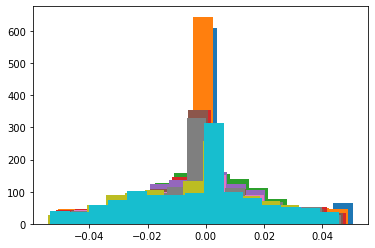

In [300]:
#training process
i=0
for epoch in range(args.epochs):
    print(f"Epoch Number {epoch + 1}")
    federated_model = train(i)
    global_model = federated_model
    #test(federated_model)#checking the test-performance of an updated gloabl model after each epoch 
    i+=20


In [293]:
#test
test(global_model)


Test set: Average loss: 0.2050, Accuracy: 9437/10000 (94%)



In [294]:
Ytest = [item for sublist in ytest for item in sublist]
predicted_y = [item for sublist in predicted for item in sublist]

#Ytest and predicted_y was still a list of list(with one element)
Ytest = [item for sublist in Ytest for item in sublist]
predicted_y = [item for sublist in predicted_y for item in sublist]
#print(len(Ytest))
#print(Ytest[90:100])
#print(predicted_y[90:100])

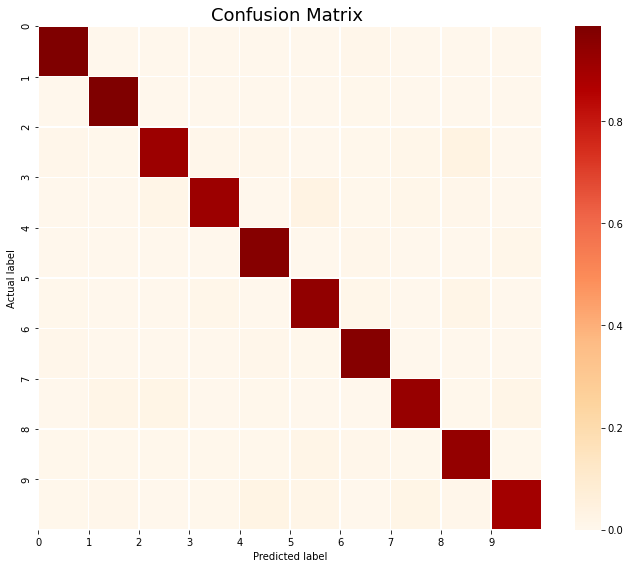

In [295]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
import numpy as np

classes=[]
for i in range(10):
  classes.append(i)

conf=confusion_matrix(Ytest,predicted_y,classes,normalize='true')

f = plt.figure(figsize=(10,8))
ax=f.add_subplot(1,1,1)
sb.heatmap(conf,annot=False, fmt=".2f", linewidths=.5,cmap='OrRd',square=True,ax=ax)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=1)
plt.yticks(tick_marks, classes)

ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
ax.set_title('Confusion Matrix ', size = 18);
plt.tight_layout()
plt.show()